In this Notebook, we aim at creating some DataDriven surrogate models for the simpliest 1D Poisson Equation: 

$$
- D \Delta u = 1
$$

with D the diffusion coefficient, considerer as scalar and constant over the whole domain. 

Our goal is to create params to solutions models, i.e a mapping from D to u.  

As we want to do it in a data driven manner, we first need a solver to generate data. To do so, we use an implicit finite difference method. 
$$
-D \frac{u_{i-1} -2u_i + u_{i+1}}{(\Delta x)^2} = 1
$$

In [1]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import torch
import random as rd
import copy

In [2]:
current_folder = os.path.dirname(os.path.abspath('__file__'))
parent_folder = os.path.dirname(current_folder)
grandparent_folder = os.path.dirname(parent_folder)
sys.path.append(grandparent_folder)

## Data Generation

First we need to generate data, to do so, we use the Solver module that will do everything for us in exchange for a dictionnary of params as input. 

There is some already recorded params in the config_step_1.py file 

In [3]:
from solvers.Solver import Solver
from config_step_1 import PARAMS_SOLVER

Poisson equation in a \[0, 1\] domain and 1001 points for discretizations

In [4]:
PARAMS_SOLVER

{'equation': 'Poisson', 'domain': [0.0, 1.0], 'D': 1.0, 'nx': 101}

In [5]:
params_solver = copy.deepcopy(PARAMS_SOLVER)
solver = Solver(params={'solver': params_solver})

In [6]:
u = solver.solve()

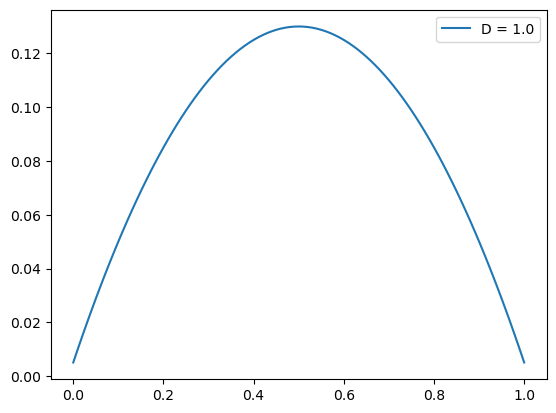

In [7]:
plt.plot(solver.x, u, label=f'D = {solver.D}')
plt.legend()
plt.show()

Now let us generate a dataset using this solver

In [8]:
Dmin, Dmax = 0.1, 10
D_list = np.linspace(Dmin, Dmax, 1000)

In [9]:
U_sols = []
for d in D_list:
    solver.change_D(d)
    U_sols.append(solver.solve())

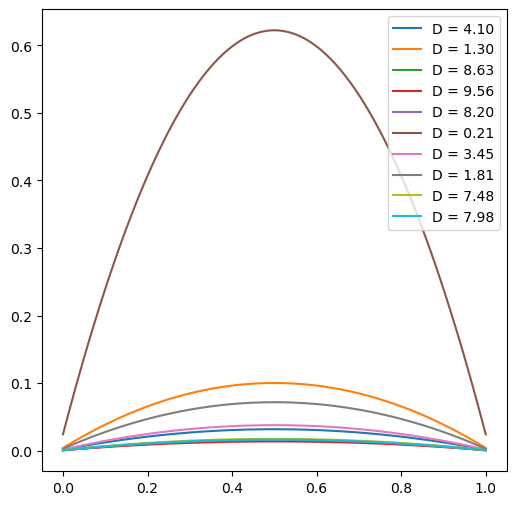

In [10]:
fig, axs = plt.subplots(1, figsize=(6, 6))
for sample in rd.sample(range(0, len(U_sols)), 10):
    axs.plot(solver.x, U_sols[sample], label=f'D = {D_list[sample]:.2f}')
plt.legend(loc=1)
plt.show()

## DataDriven surrogate models creation

Now we want to create multiple surrogate models through different methods: POD, MLP, FNO and DeepONet

In practice, we just need to call DDMethod that will handle everything for us

In [11]:
from methods.DataDrivenMethods import DDMethod

In [12]:
# chose methods that you want to use
method_names = ['POD', 'MLP', 'DEEPONET'] 

Best hyperparameters for fitting each method have already been computed using optuna (see https://optuna.readthedocs.io/en/stable/index.html), we just need to import them 

In [13]:
from config_step_1 import PARAMS_METHODS, HYPERPARAMS_METHODS

In [14]:
PARAMS_METHODS

{'POD': {'method_name': 'POD'},
 'MLP': {'method_name': 'MLP',
  'layer_dims': [1, 391, 141, 247, 114, 349, 101],
  'activations': ['relu', 'tanh', 'softplus', 'relu', 'relu'],
  'device': 'cpu',
  'seed': 123},
 'DEEPONET': {'method_name': 'DEEPONET',
  'branch': {'layer_dims': [1, 20, 20],
   'activations': 'tanh',
   'device': 'cpu',
   'seed': 123},
  'trunk': {'layer_dims': [1, 20, 20],
   'activations': 'tanh',
   'device': 'cpu',
   'seed': 123}}}

Create DDMethod object for each method

In [15]:
all_methods = {}
for method in method_names:
    params_method = copy.deepcopy(PARAMS_METHODS[method])
    params = {'solver': params_solver, 'method': params_method}
    all_methods[method] = DDMethod(params=params)

Data preparation for training 

In [16]:
# MLP/POD Data preparation
U_sols = np.stack(U_sols)
D = torch.Tensor(D_list).view(-1, 1)
U = torch.Tensor(U_sols)
D_train, D_val, U_train, U_val = sklearn.model_selection.train_test_split(D, U,test_size=0.2)

In [17]:
# DEEPONET Data preparation
D_repeated = [[d] * len(solver.x) for d in D_list]
D_repeated = torch.Tensor(D_repeated).view(-1, 1)
x = torch.Tensor(solver.x).view(-1, 1)
X = x.repeat(D_list.shape[0], 1)
DX = torch.cat((D_repeated, X), dim=1)
DX_train, DX_val, xU_train, xU_val = sklearn.model_selection.train_test_split(DX, U_sols.flatten(), train_size=0.8)

Fit all methods using fit function on DDMethod object

In [18]:
for method in method_names:
    hyperparams_method = copy.deepcopy(HYPERPARAMS_METHODS[method])
    if method == 'POD':
        all_methods[method].fit(hyperparameters=hyperparams_method, U=U_sols)
    elif method in ['MLP']:
        all_methods[method].fit(hyperparameters=hyperparams_method, U_train=U_train, U_val=U_val, D_train=D_train, D_val=D_val)
    elif method == 'DEEPONET':
        all_methods[method].fit(hyperparameters=hyperparams_method, U_train=xU_train, U_val=xU_val, DX_train=DX_train, DX_val=DX_val)

Fitting POD
POD fitted
Fitting MLP
MLP fitted
Fitting DEEPONET
DEEPONET fitted


# Plot performances for each method

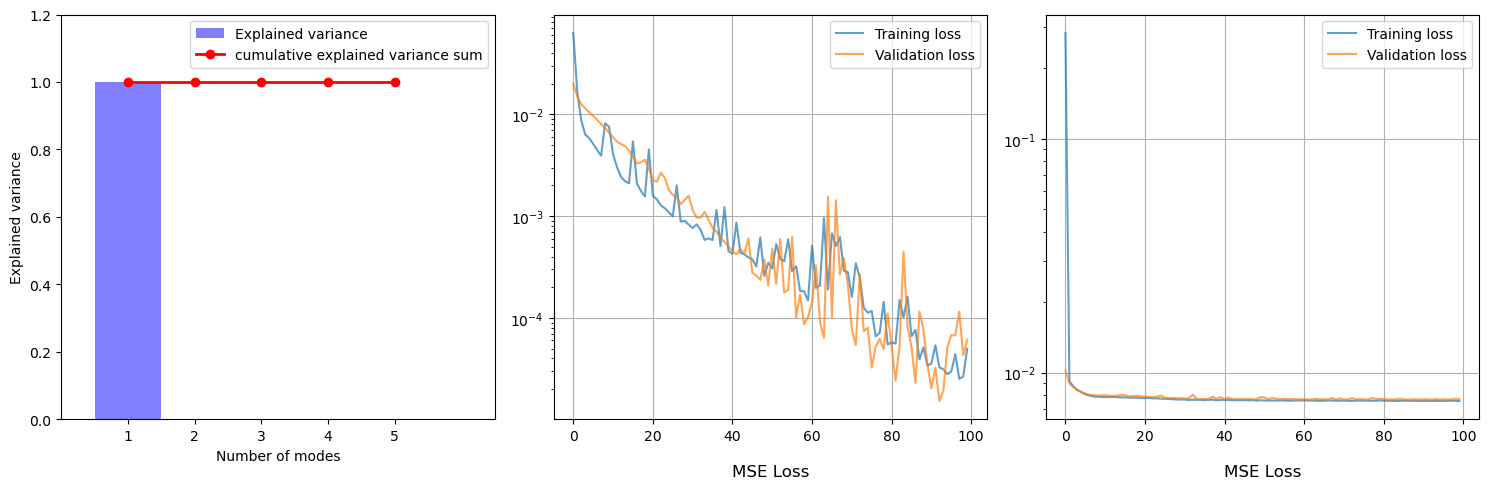

In [25]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
all_methods['POD'].plot(ax1)
all_methods['MLP'].plot(ax2)
all_methods['DEEPONET'].plot(ax3)
fig.tight_layout()
plt.show()

## In distribution analysis

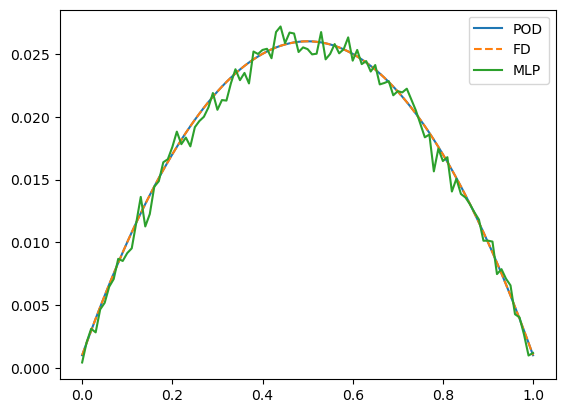

In [20]:
new_D = 5.
solver.change_D(new_D=new_D)
U_FD = solver.solve()
U_MLP = all_methods['MLP'].apply_method(new_D).detach().numpy()
U_POD = all_methods['POD'].apply_method(new_D)
plt.plot(solver.x, U_POD, label='POD')
plt.plot(solver.x, U_FD, '--', label='FD')
plt.plot(solver.x, U_MLP, label='MLP')
plt.legend()
plt.show()

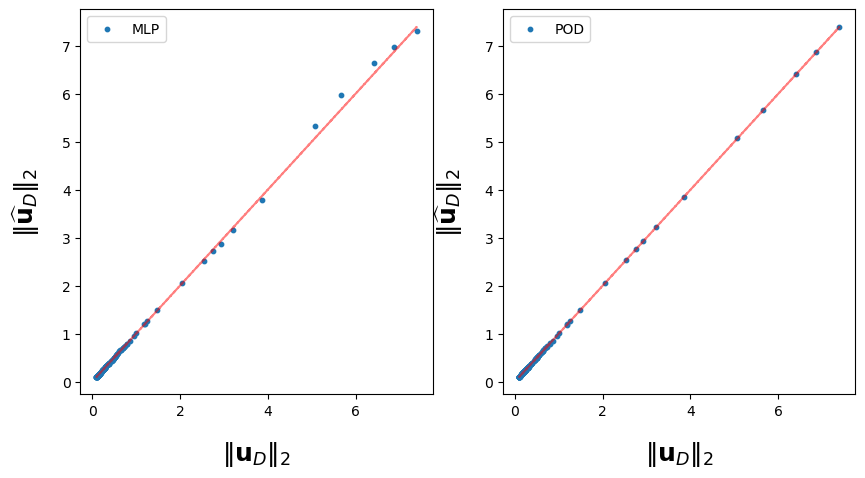

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
all_methods['MLP'].parity_plot(U=U_val, D=D_val, ax=ax1, label='MLP')
all_methods['POD'].parity_plot(U=U_val, D=D_val, ax=ax2, label='POD')
ax1.legend()
ax2.legend()
plt.show()

## Out of Distribution

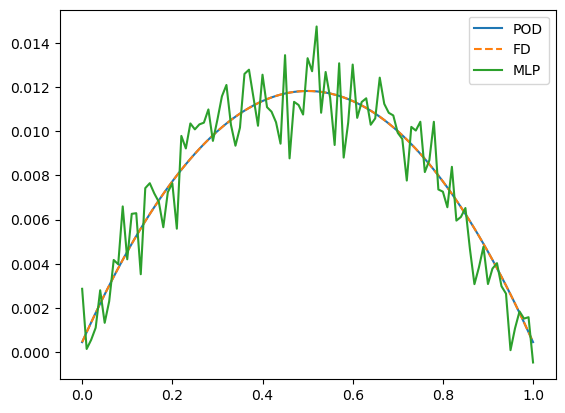

In [22]:
new_D = 11.
solver.change_D(new_D=new_D)
U_FD = solver.solve()
U_MLP = all_methods['MLP'].apply_method(new_D).detach().numpy()
U_POD = all_methods['POD'].apply_method(new_D)
plt.plot(solver.x, U_POD, label='POD')
plt.plot(solver.x, U_FD, '--', label='FD')
plt.plot(solver.x, U_MLP, label='MLP')
plt.legend()
plt.show()

## Parity plot

In [23]:
OOD_D = np.linspace(10, 20, 101)
U_OOD_FD = []
for d in OOD_D:
    solver.change_D(new_D=d)
    U_OOD_FD.append(solver.solve())

U_OOD_FD = np.stack(U_OOD_FD)
OOD_D = torch.Tensor(OOD_D).view(-1, 1)
U_OOD_FD = torch.Tensor(U_OOD_FD)

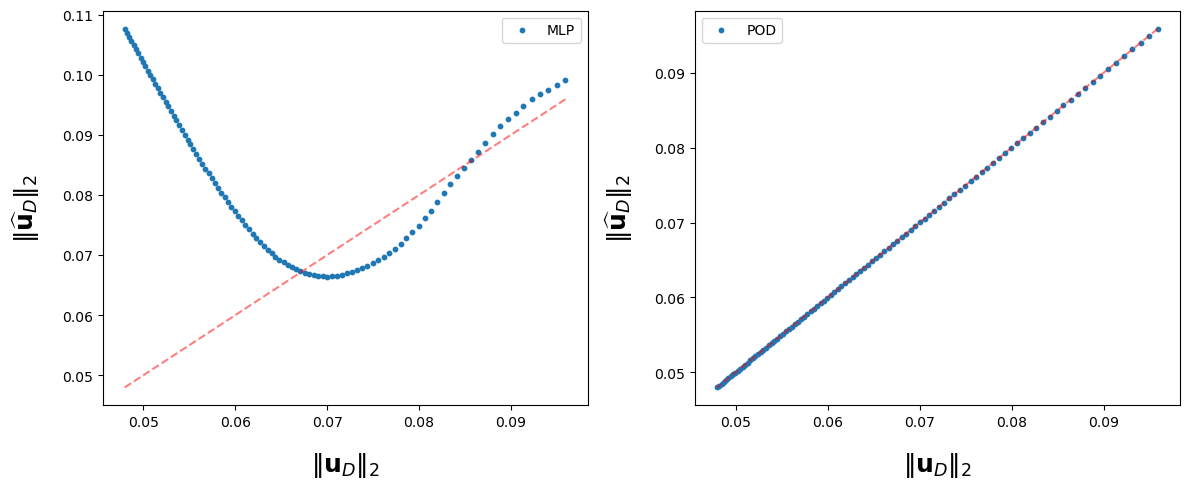

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
all_methods['MLP'].parity_plot(U=U_OOD_FD, D=OOD_D, ax=ax1, label='MLP')
all_methods['POD'].parity_plot(U=U_OOD_FD, D=OOD_D, ax=ax2, label='POD')
ax1.legend()
ax2.legend()
plt.tight_layout()
plt.show()